In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
import exploratory_analysis as ea
%matplotlib inline

In [3]:
df = pd.read_csv('../data/train.csv', low_memory=False)

### Clean SAT

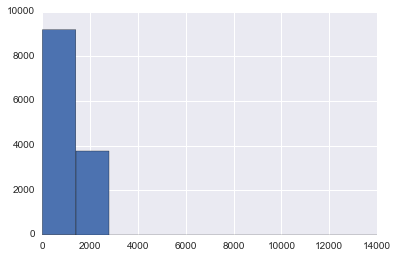

In [4]:
sat_scores = df['Highest Composite SAT Score']
sat_scores.hist()

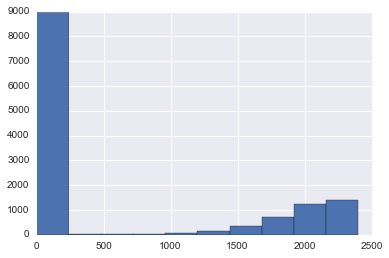

In [5]:
sat_scores[sat_scores<=2400].hist()

There's a a fair amount of nonsensical scores. Let's set all scores that are 0, under 600 (min score), or above 2400 (max score) to None.

In [6]:
df['Highest Composite SAT Score'] = df['Highest Composite SAT Score'].apply(lambda x: None if x>2400 or x<600 else x)

We have to be careful about SAT scores here:
- In 2005, the maximum score was raised to 2400 (from 1600).
- In 2016, the maximum score returned to 1600.

We shouldn't have to worry too much about the 2016 test-takers, since they would have only had a few months to take it (from the score change until the date of this analysis), and would not have been accepted to a college in that time frame, let alone applied to any. We may, however, have to scale the scores of pre-2005 test-takers from a 1600 to 2400 point scale. Let's see if there are outliers/weird data.

Let's first look at the distribution of scores where Undergradate Graduation Year < 2010, bc we assume people take SATs in their junior year of high school, i.e. take SAT in 2005, graduate HS in 2006, graduate college in 2010.

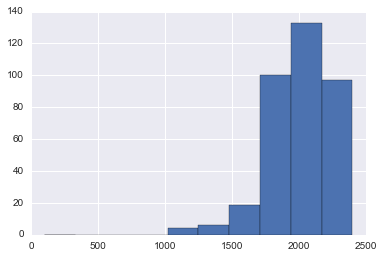

In [11]:
ea.histogramSAT(df, 2010, 'before')

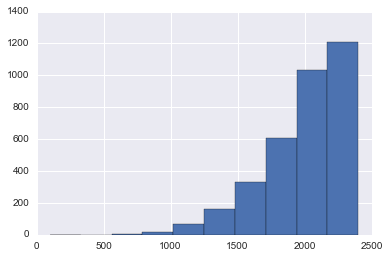

In [14]:
ea.histogramSAT(df, 2009, 'after')

Let's see if can get more accurate scores by looking at the 'Highest SAT Scores' column. 

There is no standard format in which these scores are listed. They are all separated by whitespace (\n), but the number of scores are inconsistent- some have 2, some have 3, some have 4. We'll have to create some detailed rule that parses through the text to determine what the person's total score is.

Let's create a new column called 'SAT_total_temp' and store our parsed values there.

In [16]:
df['SAT_total_temp'] = df['Highest SAT Scores'].apply(lambda x: ea.parseSAT(x) if type(x)==str else x)

Note that our parseSAT function couldn't parse out the rows with irregular number of scores, but that doesn't matter, since most of them only have one score (which not only isn't helpful, most of them are 1's - nonsense). A very small minority have detailed scores but we can just impute something for them later. Let's take a look at the distribution again.

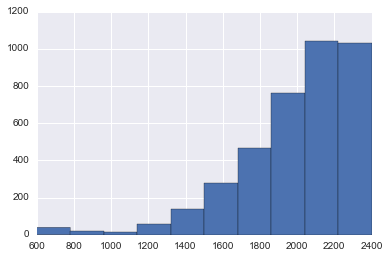

In [17]:
df['SAT_total_temp'].hist()

From inspection, it looks like all scores < 1600 are on a 2400-point scale (almost all have three scores in the 'Highest SAT Scores box'). No point conversion is needed. While we're not sure which score is correct, we can just take the larger of the two columns.

In [18]:
reload(ea)
ea.finalizeSAT(df)

In [19]:
df['SAT_total_final'].describe()

count    4277.000000
mean     1980.692425
std       320.288947
min       600.000000
25%      1810.000000
50%      2050.000000
75%      2220.000000
max      2400.000000
Name: SAT_total_final, dtype: float64

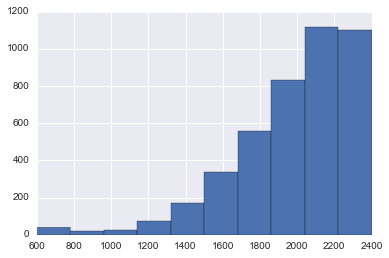

In [20]:
df['SAT_total_final'].hist()

SAT scores now look good for data processing.

### SAT (times taken)

In [21]:
df['How many times did you take the official SAT?'].value_counts()

2    1848
1    1211
3     713
0      65
Name: How many times did you take the official SAT?, dtype: int64

In [22]:
df['SAT_times_taken'] = df['How many times did you take the official SAT?'].copy()

### Clean High School GPA

In [23]:
df['High School GPA'].describe()

count    12925.000000
mean         1.868832
std          3.220446
min          0.000000
25%          0.000000
50%          0.000000
75%          3.860000
max        100.000000
Name: High School GPA, dtype: float64

Two observations: the vast majority are 0s, and the max is 101. Let's remove these first.

In [24]:
df['High School GPA'] = df['High School GPA'].apply(lambda x: np.nan if x==0 or x>100 else x)

In [25]:
df['High School GPA'].describe()

count    6055.000000
mean        3.989207
std         3.698709
min         1.500000
25%         3.600000
50%         3.900000
75%         4.190000
max       100.000000
Name: High School GPA, dtype: float64

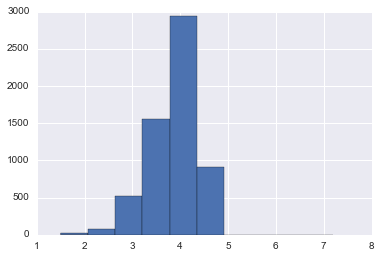

In [26]:
df[df['High School GPA']<50]['High School GPA'].hist()

Couple more observations:
- Over half of GPA's are 4.0 or below
- A handful of GPAs are between 4 and 4.5
- A minority of GPAs are above 4.5- some are out of 100, some are on an arbitrary scale/typos

Let's not use the GPA scores 2.0 or below (set to nan)

In [27]:
df['High School GPA'] = df['High School GPA'].apply(lambda x: np.nan if x<=2 else x)

Taking a look at scores between 4 and 5:

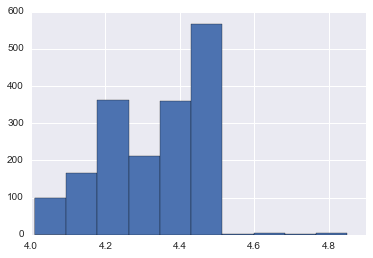

In [28]:
df[(df['High School GPA']>4)&(df['High School GPA']<5)]['High School GPA'].hist()

We don't have reliable info as to what the GPA scales are for these scores, but it looks like there are two separate distributions, one for a 4.2 scale, and one for a 4.5 scale, and a small number of datapoints in what looks like a 5 scale. Our best option at this point is to set these to the 4.0-scale median.

In [29]:
GPA_median = df[df['High School GPA']<=4]['High School GPA'].median()
df['High School GPA'] = df['High School GPA'].apply(lambda x: GPA_median if x>4 else x)

(2, 4.1)

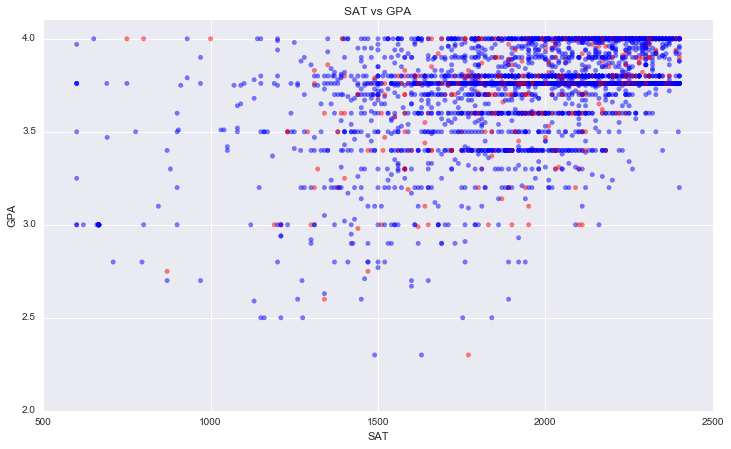

In [30]:
plt.figure(figsize=(12,7))
plt.scatter(df['SAT_total_final'], df['High School GPA'], color=['r' if x==1 else 'b' for x in df['top_school_final']],
            alpha=0.5)
plt.title('SAT vs GPA')
plt.xlabel('SAT')
plt.ylabel('GPA')
plt.ylim([2,4.1])

Unfortunately it doesn't look like GPA and SAT have a strong bearing on whether someone is accepted in a top school. Let's continue with other variables

### Gender

In [31]:
df['Male'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

### Ethnicity

In [32]:
df['Ethnicity'].value_counts()[:10]

White Non-Hispanic                             4099
Asian                                          1841
Black / African American                       1470
Hispanic                                       1253
Prefer Not to Share                             378
Asian|White Non-Hispanic                        161
Black / African American|White Non-Hispanic     131
Native American                                  84
Hispanic|White Non-Hispanic                      72
Black / African American|Hispanic                59
Name: Ethnicity, dtype: int64

In [33]:
df['Ethnicity2'] = df['Ethnicity'].apply(lambda x: ea.parseEthnicity(x) if type(x)==str else x)

In [34]:
df['Ethnicity_Asian'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'asian' in x else 0)
df['Ethnicity_Black'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'black / african american' in x else 0)
df['Ethnicity_Hispanic'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'hispanic' in x else 0)
df['Ethnicity_White'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'white non-hispanic' in x else 0)
df['Ethnicity_Pacific'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'native hawaiian / pacific islander' in x else 0)
df['Ethnicity_NativeAm'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'native american' in x else 0)

In [35]:
for c in df.columns:
    if c.find('Ethnicity_')>-1:
        print c, df[c].sum()

Ethnicity_Asian 2215
Ethnicity_Black 1814
Ethnicity_Hispanic 1500
Ethnicity_White 4578
Ethnicity_Pacific 112
Ethnicity_NativeAm 185


### High School Activities / Leadership / Honors

In [36]:
df['High School Extracurricular Activities'].notnull().sum()

3497

In [43]:
ea.showTopPhrases(df, 'High School Extracurricular Activities', n=30)

[('Member', 5821),
 ('2', 3542),
 ('4', 3514),
 ('3', 2594),
 ('1', 2376),
 ('Lead role', 2251),
 ('School Award', 2014),
 ('Regional/State Recognition', 1311),
 ('President', 1284),
 ('National Honor Society', 1259),
 ('Executive Board', 1113),
 ('Recognized in Local Media', 1053),
 ('Community Award', 921),
 ('Tutoring/Mentoring', 688),
 ('National Recognition', 672),
 ('Committee Leader', 643),
 ('Student Council / Government', 616),
 ('Founder', 554),
 ('Awarded Monetary Prize', 475),
 ('Community Cleanup / Service', 472),
 ('Received Scholarship For Achievement', 439),
 ('School Newspaper/Magazine/Journalism', 402),
 ('Debate Club/Team', 398),
 ('Won National Award', 385),
 ('Science Club/Team', 355),
 ('Key Club', 340),
 ('Church', 330),
 ('School theater/plays', 319),
 ('Math Team', 299),
 ('Choir', 282)]

In [44]:
leader_words = ['leader','president','founder']
arts_words = ['arts', 'music', 'jazz', 'band', 'orchestra', 'choir', 'drama', 'theater']
award_words = ['award', 'scholarship', 'achievement', 'prize']
community_words = ['volunteer', 'community','cleanup', 'ngo', 'environment', 'humanity','green', 'charity']
academic_words = ['science', 'math', 'engineering']
gov_words = ['debate', 'model', 'government']
diversity_words = ['alliance', 'multicultural', 'diversity']
race_words = ['naacp','asian','jewish','german','french','japanese','italian','chinese']

In [ ]:
ecc_colnames = ['leader','arts','award','community','academic','gov','diversity','race_ecc']
ecc_words = [leader_words, arts_words, award_words, community_words, academic_words, gov_words, diversity_words, race_words]
for colname, words in zip(ecc_colnames, ecc_words):
    df[colname] = df['High School Extracurricular Activities'].apply(lambda x: ea.parseECC(x, words))

### Sports

In [46]:
df['High School Sports Played'].notnull().sum()

2693

In [159]:
# re.findall('[[]\S+[]]\s[[]\S+[]]\s(.+)', df[df['High School Sports Played'].notnull()]['High School Sports Played'].values[2])

In [102]:
all_sports = list(df['High School Sports Played'].apply(ea.getAllSports))
unique_sports = ea.getUniqueSports(all_sports)

In [135]:
# Initialize dummy variables for each sport category, set to 0s.
ea.makeSportsDummies(df, unique_sports)

In [137]:
# Fill in the dummy variables for each sport category accordingly (1 if that sport was played)
ea.parseSports(df, unique_sports)

In [157]:
# Create a varsity dummy variable that indicates if someone played sports at a varsity level
df['sportsVarsity'] = df['High School Sports Played'].apply(lambda x: ea.parseVarsity(x, unique_sports))
# Create a varsity dummy variable that indicates if someone was a captain of a sport
df['sportsCaptain'] = df['High School Sports Played'].apply(lambda x: ea.parseCaptain(x, unique_sports))

### Home Country

In [160]:
df['Home Country'].value_counts()[:10]

[1703] [united-states] United States    9548
[1793] [india] India                      64
[1738] [canada] Canada                    43
[1744] [china] China                      43
[1837] [morocco] Morocco                  33
[1794] [indonesia] Indonesia              33
[1830] [mexico] Mexico                    26
[1861] [philippines] Philippines          22
[1790] [hong-kong] Hong Kong              21
[1849] [nigeria] Nigeria                  21
Name: Home Country, dtype: int64

In [161]:
df['Home Country'] = df['Home Country'].apply(lambda x:re.search('[[]\S+[]]\s[[]\S+[]]\s(.+)', x).group(1)
                                              if type(x)==str else x)

In [162]:
df['Home Country_US'] = df['Home Country'].apply(lambda x: 1 if x=='United States' else 0)

### Academic Performance in HS

In [166]:
df['Academic Performance in High School'].value_counts()

Steady                         3250
Low at first but improved       390
Some good some bad              384
Low one semester/year           226
High at first but got worse      76
Name: Academic Performance in High School, dtype: int64

In [173]:
reload(ea)
ea.exploreCategorical(df, 'Academic Performance in High School','top_school_final',2,3)

KeyError: 'Academic Performance in High School'

Almost 30% of those who had 'Steady' grades in high school ended up getting into a top school - there could be something interesting here...

In [170]:
df = pd.get_dummies(df,columns=['Academic Performance in High School'], prefix='HS')

In [190]:
df.columns.values

array(['Unnamed: 0', 'id', 'Gender', 'Undergraduate Schools Attended',
       'Undergraduate Graduation Year', 'Undergraduate Major(s)',
       'Ethnicity', 'Home State or Territory (US)', 'Home City',
       'High School Type', 'High School GPA', 'High School Class Rank',
       'High School AP / IB Classes and Scores',
       'Undergraduate Additional Info',
       'High School Extracurricular Activities',
       'High School Sports Played', 'High School Other Honors and Awards',
       'Undergraduate Acceptance', 'Undergraduate Month Applied',
       'Undergraduate Schools Applied', 'Who are you?', 'About Me',
       'Birth Year', 'Home Country', 'Is English your first language?',
       'Do you speak other languages?', 'Undergrad Legacy',
       'Undergraduate Degree Type', 'Undergraduate Type of Major(s)',
       'Highest SAT Scores',
       'How many times did you take the official SAT?',
       'SAT 2 Tests Taken and Highest Scores',
       'Undergraduate Personal Statement Topi